In [1]:
@time include("ready.jl")

┌ Warning: Message type 'Bool' conflicts with Julia builtin, will be imported as 'BoolMsg'
└ @ RobotOS /home/yangbo/.julia/packages/RobotOS/j0Tsl/src/gentypes.jl:181
┌ Warning: Message type 'Float64' conflicts with Julia builtin, will be imported as 'Float64Msg'
└ @ RobotOS /home/yangbo/.julia/packages/RobotOS/j0Tsl/src/gentypes.jl:181



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

complete initialization
 42.691378 seconds (158.69 M allocations: 9.758 GiB, 6.86% gc time, 0.00% compilation time)


In [4]:
β_controller = PID(Kp=1.0, Ki=0.0006, Kd=50.0, sign=1)
R_controller = PID(Kp=5.0, Ki=0.05, Kd=5.0, sign=-1)
phase = 1
t1 = 0
t12 = 0
Cx = 0
Cy = 0

reference.R_ref = 1.0
reference.β_ref = -1.35

function control_fn!(i, state, input, exstate, reference, robo)

    global theta
    global Cx, Cy
    
    R0 = 1
    β = exstate.β
    R = exstate.R
    R_ref = reference.R_ref
    β_ref = reference.β_ref
    R_l1ac = reference.R_l1ac
    
    δ_ff = 0.05
    ω_ff = 4.0
    ω0 = input.ω
    
    err = round_angle(β - β_ref)
    δ = clamp(δ_ff + controla!(β_controller, err), 0, π / 8)
    
    s = state
    
    
    if i > 0
        Cx = robo.x
        Cy = robo.y
    end
    
    if i % 2 == 0
        if i > 1000
            θ1 = atan(Cy - s.y, Cx - s.x)
            θ2 = atan(s.vy, s.vx)
            Δθ = round_angle(θ1 - θ2)
            dis = sqrt((s.x - Cx) ^ 2 + (s.y - Cy) ^ 2)
            ΔR = 0.5 * tanh(dis) * cos(Δθ)
            R_ref = R0 + ΔR
            reference.R_ref = R_ref
        end
        if i < 1000
            #R_l1ac = L1AC!(l1ac, convert(Float64,R_ref), est_circle.r, 0.10)
            #reference.R_l1ac = R_l1ac
            ω0 = 4.0
           #err = R - R_ref
           #ω0 = clamp(ω_ff + controla!(R_controller,err),3,7)
        else
            err = R - R_ref
            ω0 = clamp(ω_ff + controla!(R_controller,err),3,7)
        end
    end
    ω = ω0
    return δ, ω
end

function reset_fn()
    β_controller.err_sum = 0
    β_controller.last_err = 0
    R_controller.err_sum = 0
    R_controller.last_err = 0
    phase = 1
    reference.R_ref = 1.0
    reference.β_ref = -1.2
    Cx = 0
    Cy = 0
end

init_node("Controller", disable_signals=true)
sub1 = Subscriber{RosMsg.PoseStamped}("/vrpn_client_node/racecar/pose", update_rts, queue_size=1)
sub2 = Subscriber{RosMsg.Imu}("/imu", update_imu, queue_size=1)
sub3 = Subscriber{RosMsg.BoolMsg}("/Safe", update_safe, queue_size=1)
sub4 = Subscriber{RosMsg.PoseStamped}("/vrpn_client_node/robomaster/pose", update_robo, queue_size=1)
pub = Publisher{RosMsg.VescCtrlStamped}("/vesc/ctrl", queue_size=1)
data = control_wrapper(pub, control_fn!, reset_fn);

Interrupted


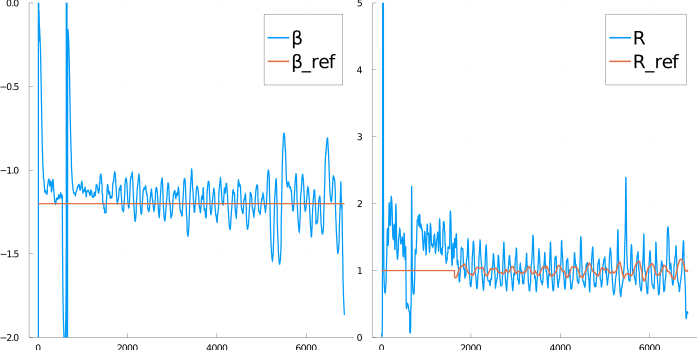

In [5]:
p1 = plot([p.es.β for p in data],label="β")
plot!(p1, [p.ref.β_ref for p in data],label="β_ref")
p2 = plot([p.es.R for p in data],label="R")
plot!(p2, [p.ref.R_ref for p in data],label="R_ref")
ylims!(p1,-2,0)
ylims!(p2,0,5)
plot(p1,p2,size = (2800, 1400),xtickfontsize=25,ytickfontsize=25,legendfontsize=50,width=5)

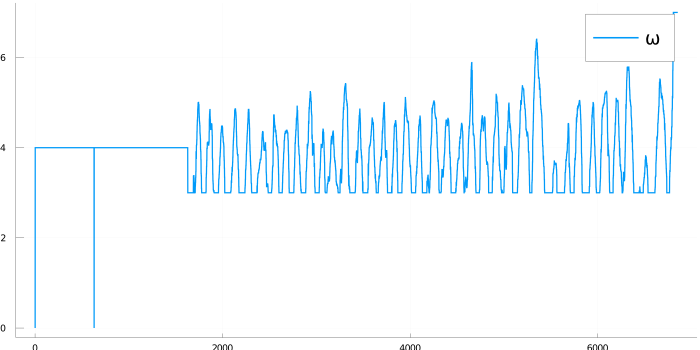

In [7]:
p3 = plot([p.u.ω for p in data],label="ω")
plot(p3,size = (2800, 1400),xtickfontsize=25,ytickfontsize=25,legendfontsize=50,width=5)